# Resolution Matcher: A Self-Simplifying Program for Fire Perimeters

- Topic: Wildfire Perimeter mapping; satellite versus aircraft instrument observations
- Goals:
    - Of interest to wildfire researchers is to find a way to quantify how much “simpler” satellite fire perimeter estimates are from aircraft observations
    - While it could be possible to just take the resolution of the two products, intricacies such as swath angle, tilt, and varying topography impact the resolution of each product
    - Ultimate goal: produce a program that given a “truth” polygon and “estimate” polygon, recursively optimizes the “estimate” polygon to be the closest match to the “truth”. Outside of typical shape algorithms, apply extra factors such as topography, fuel type, etc to influence the final shape
    - Topography, fuel type, and average weather behavior have an extreme influence on fire behavior; being able to lay over datasets and possibly predict corrections could help adjust future satellite products
    
- Considerations/challeneges:
    - Date matching
    - Satellite has no name sorting officially in the API
    - Cannot always assume its aircraft method
    - NIFC / fire management database is imperfect in labeling/geometry sorting


## About the Data

- NASA FEDS Archived
- NIFC Archived 

## About the files
- `main.ipynb`: this is the key file that demonstrates the project workflow
- `api_access.py`: all functions managing api access 
- `calculations.py`: all functions for polygon calculations
- `best_simplify.py`: simplification algorithm which uses feedback from calculations to identify performance

In [1]:
import sys
import os

from satellite import SatelliteDetection
from aircraft import AircraftDetection

from search_iterator import *
from calculations import *
from best_simplify import *
from Utilities import *

In [2]:
# call smart iterator with set inputs 

year_start = 2019
month_start = 10
day_start = 1

year_end = 2019
month_end = 12
day_end = 20

# 48.642283, -125.006740
# 26.522897, -77.225943


bbox = ["-125.0", "24.396308", "-66.93457", "49.384358"] # ["-122.887312", "38.560242", "-122.601345", "38.813395"] # ["-125.006740", "26.522897", "-77.225943", "48.642283"] # ["-123.894958","39.529218","-122.290878","40.634026"] # e.g. california
crs = 3857 # 4326 # recommended 

# start search
master_matches, all_aircraft_polygons, all_satellite_polygons = init_search(year_start, 
                                                                            month_start,
                                                                            day_start, 
                                                                            year_end, 
                                                                            month_end,
                                                                            day_end, 
                                                                            bbox,
                                                                            crs)

You may see an ERROR 1 occur; ignore this unless block throws actual exception...
You may see WARNING:fiona.ogrext:Expecting property name enclosed in double quotes: line 1 column 2 (char 1); you can ignore this error safely
DEBUG in __fetch_api_collection: extent / meta data: {'spatial': {'bbox': [[-125.01170994228654, 31.67479552365894, -100.99882037044597, 49.5160148262177]], 'crs': 'http://www.opengis.net/def/crs/OGC/1.3/CRS84'}, 'temporal': {'interval': [['2018-01-02T12:00:00+00:00', '2021-12-31T12:00:00+00:00']], 'trs': 'http://www.opengis.net/def/uom/ISO-8601/0/Gregorian'}}


ERROR 1: PROJ: proj_create_from_database: Open of /projects/env-feds/share/proj failed
ERROR:fiona._env:fread(635) failed on DBF file.
ERROR:root:FAILED: No matching dates found even with provided day search range window: 7, critical benchmarking failure.
ERROR:root:FAILED: No matching dates found even with provided day search range window: 7, critical benchmarking failure.


## Printing and Plotting Sample results

Listed `master_matches` which represent indices for the following sets:
- all_aircraft_polygons
- all_satellite_polygons

In [16]:
# debug verbose info
# print(all_aircraft_polygons.crs)
# print(all_satellite_polygons.crs)
# print(len(all_aircraft_polygons))

## Post-data processing (lining up indices and fetching successful matches)

In [133]:
# iterate and capture only tuples best matching
non_nones = []
corresponding_indices = []

for val_set in master_matches:
    get_tuple = val_set[0]
    check = get_tuple[1]
    if check is None:
        continue
    else:
        index_extract = all_satellite_polygons.iloc[val_set[0][0]]['index']
        corresponding_indices.append(index_extract)
        non_nones.append(get_tuple)
        
# print(non_nones)
# print(corresponding_indices)

final_index_pairs  = [(replace, original[1]) for replace, original in zip(corresponding_indices, non_nones)]

print('final index pairs, fixed to proper metadata')
print(final_index_pairs)

final index pairs, fixed to proper metadata
[(8113, 11426), (7808, 11287), (7716, 11374), (7962, 11449)]


## Plot Entire Datasets against each other

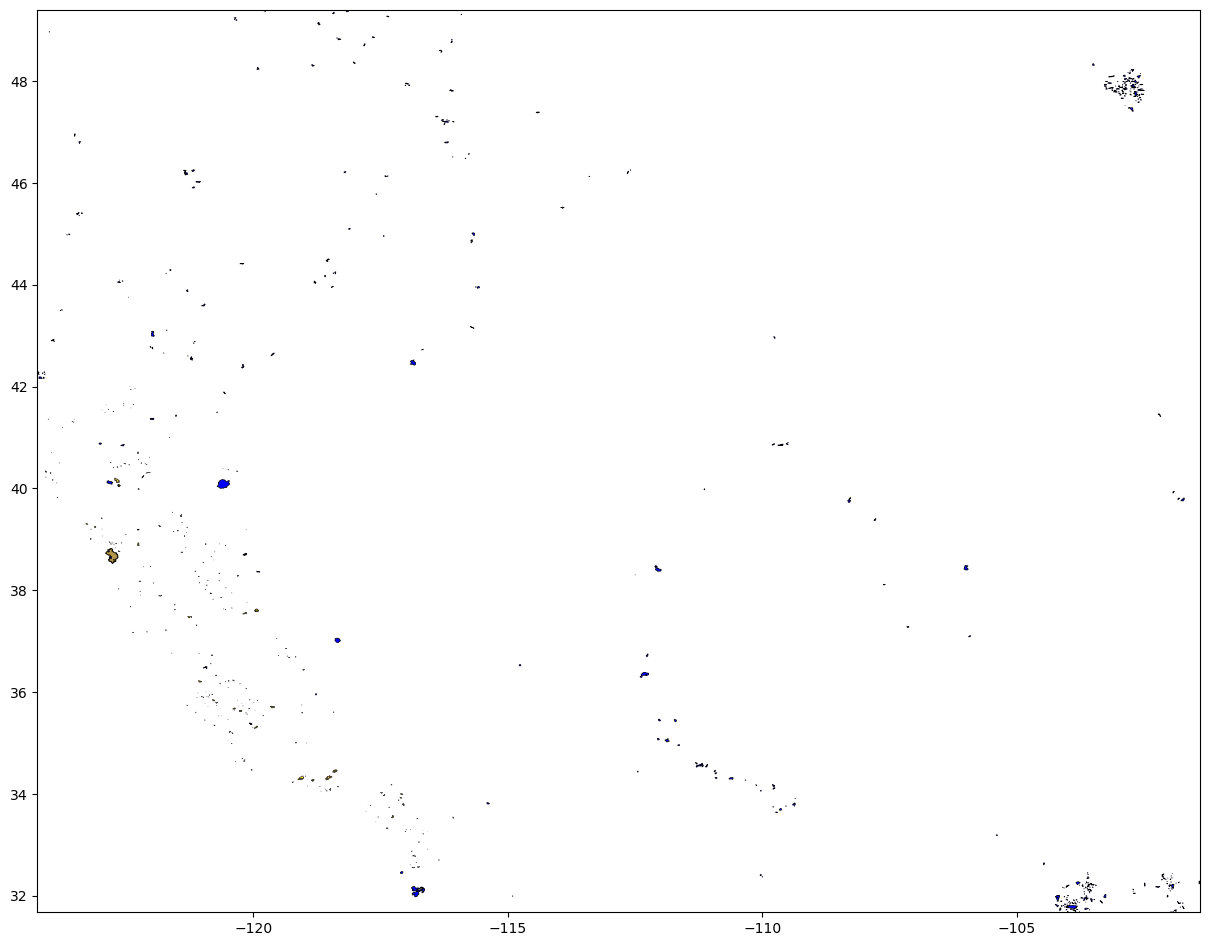

In [9]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15, 15))

all_satellite_polygons.plot(ax=ax, legend=True, label="SATELLITE MATCH", color="blue",edgecolor="black", linewidth=0.5 )
all_aircraft_polygons.plot(ax=ax, legend=True, label="CALFIRE MATCH", color="gold", edgecolor="black", linewidth=0.5, alpha=0.7)

xmin, ymin, xmax, ymax = all_satellite_polygons.geometry.total_bounds

# Set axis limits to zoom into the bounding box of 'sat_fire'
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
plt.show()

## Plot explicit matches by indexes

SATELLITE META DATA
                                               geometry  duration      farea  \
8113  POLYGON ((-119.967 37.598, -119.967 37.598, -1...       1.0  12.037027   

      fireid   flinelen     fperim   meanfrp  n_newpixels  n_pixels  ogc_fid  \
8113  F13258  11.647291  15.105974  9.113095           42        66   108976   

        pixden                    t  index  
8113  5.483081  2019-10-08T00:00:00   8113  


AIRCRAFT META DATA
       OBJECTID                MAP_METHOD  DATE_CUR  \
11426     11427  Mixed Collection Methods  20191020   

                                               COMMENTS GEO_ID IRWINID  \
11426  IR Heat Perimeter with some corrections from GPS  42617    None   

                UNQE_FIRE_ FIRE_YEAR LOCAL_NUM   INCIDENT UNIT_ID POO_RESP_I  \
11426  2019-CAMMU-00021257      2019  00021257  BRICEBURG   CAMMU       None   

      FEATURE_CA  GIS_ACRES USER_NAME        SOURCE AGENCY  FIRE_YEAR_  \
11426   Wildfire    5508.35      None  CalFire FRAP 

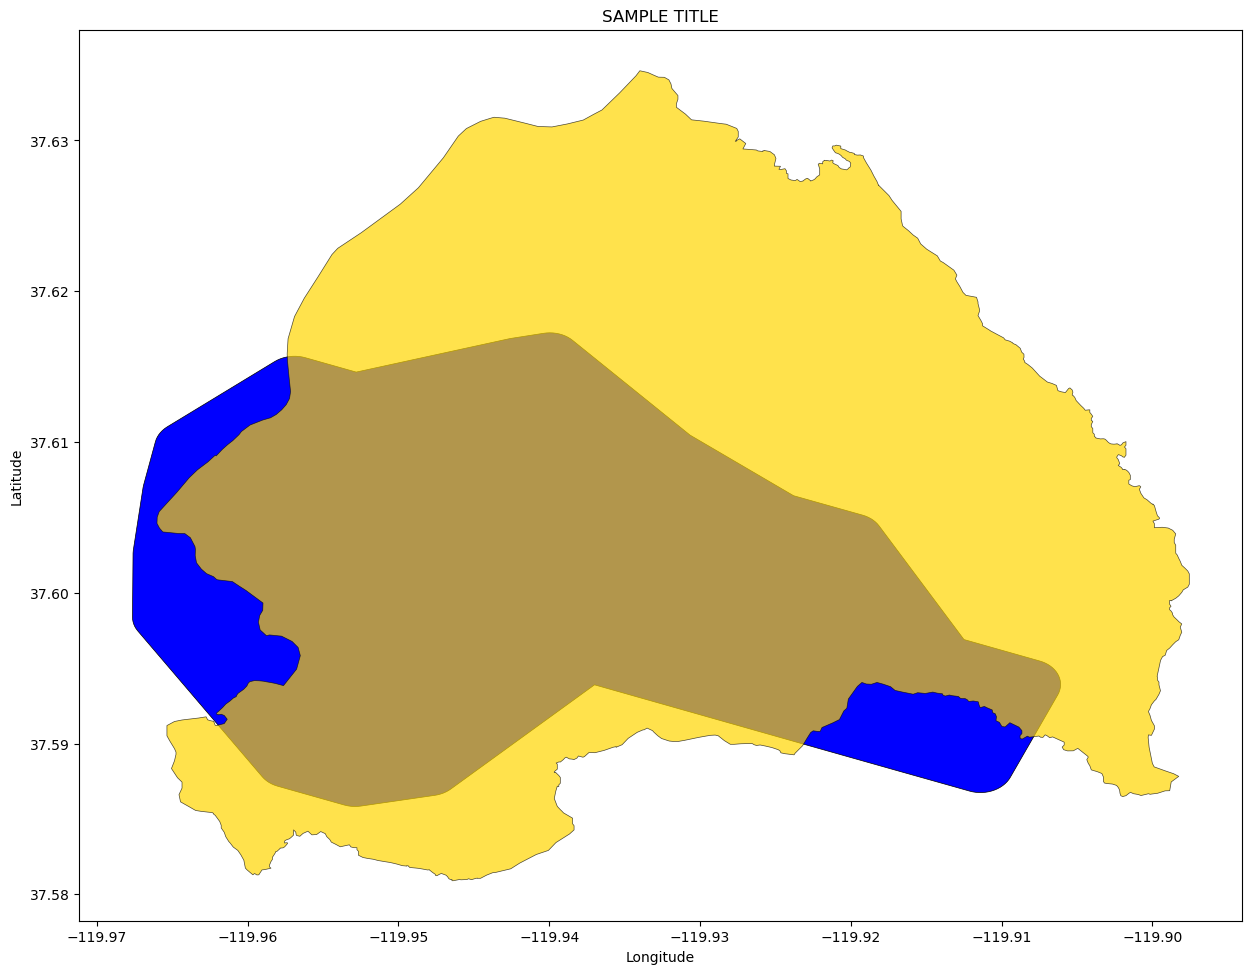

In [13]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15, 15))

sat_fire = all_satellite_polygons[all_satellite_polygons['index'] == 8113] 
aircraft_fire = all_aircraft_polygons[all_aircraft_polygons['index'] == 11426]

v = sat_fire.plot(ax=ax, legend=True, label="SATELLITE MATCH", color="blue",edgecolor="black", linewidth=0.5 )
n = aircraft_fire.plot(ax=ax, legend=True, label="AIRCRAFT MATCH", color="gold", edgecolor="black", linewidth=0.5, alpha=0.7)
# n = all_aircraft_polygons.plot(ax=ax, legend=True, label="CALFIRE MATCH", color="gold", edgecolor="black", linewidth=0.5, alpha=0.7)

print("SATELLITE META DATA")
print(sat_fire)
print("\n")
print("AIRCRAFT META DATA")
print(aircraft_fire)

ax.set_title("SAMPLE TITLE")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.show()

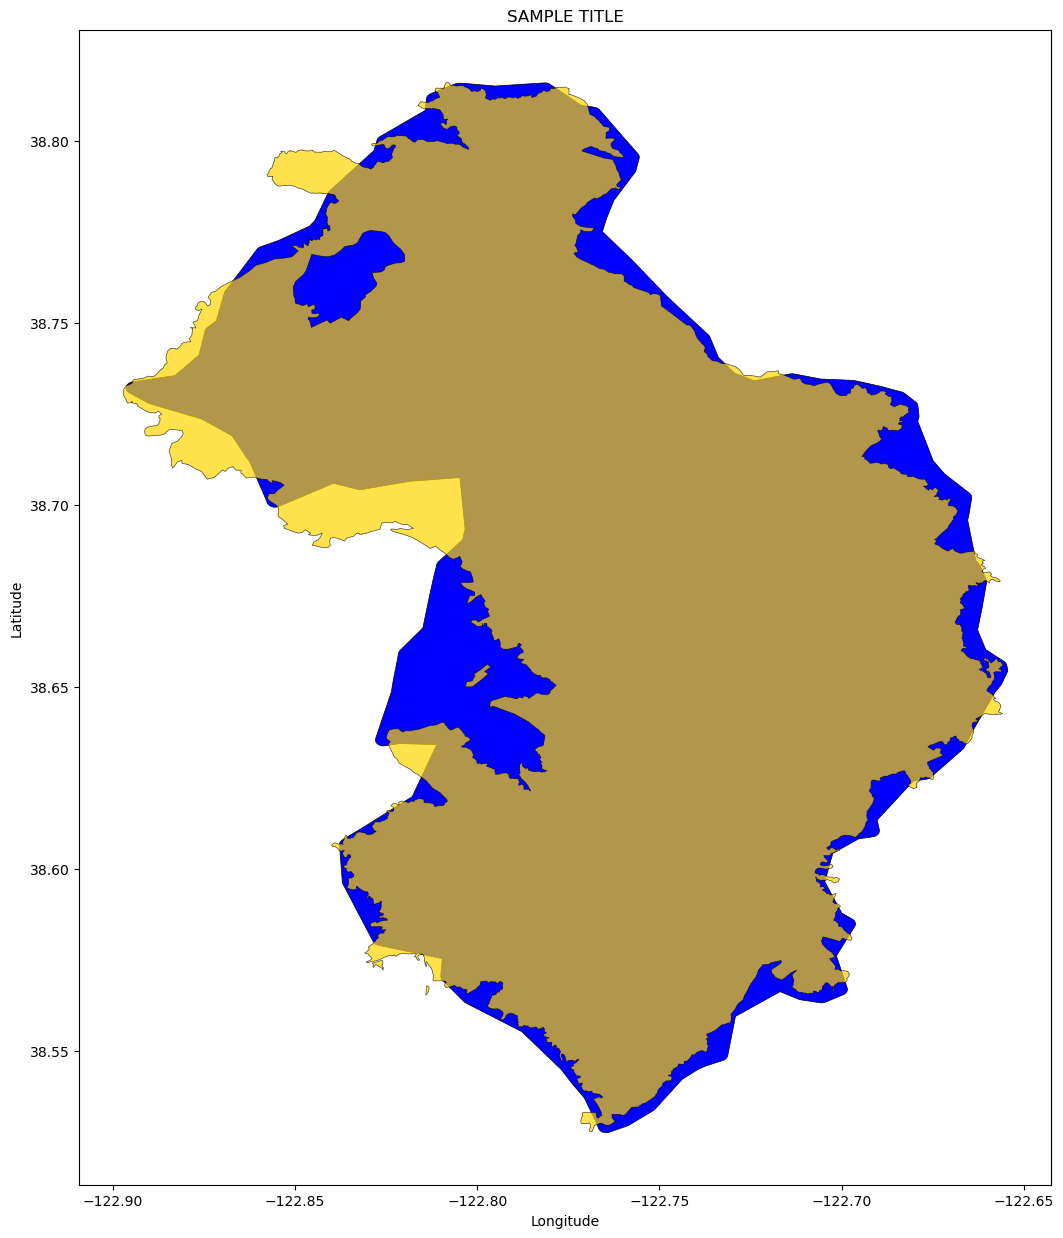

In [11]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15, 15))

sat_fire = all_satellite_polygons[all_satellite_polygons['index'] == 7808] 
aircraft_fire = all_aircraft_polygons[all_aircraft_polygons['index'] == 11287]

v = sat_fire.plot(ax=ax, legend=True, label="SATELLITE MATCH", color="blue",edgecolor="black", linewidth=0.5 )
n = aircraft_fire.plot(ax=ax, legend=True, label="AIRCRAFT MATCH", color="gold", edgecolor="black", linewidth=0.5, alpha=0.7)
# n = all_aircraft_polygons.plot(ax=ax, legend=True, label="CALFIRE MATCH", color="gold", edgecolor="black", linewidth=0.5, alpha=0.7)


ax.set_title("SAMPLE TITLE")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

xmin, ymin, xmax, ymax = sat_fire.geometry.total_bounds

# Set axis limits to zoom into the bounding box of 'sat_fire'
# ax.set_xlim(xmin, xmax)
# ax.set_ylim(ymin, ymax)

plt.show()

SATELLITE META DATA
                                               geometry  duration      farea  \
7716  POLYGON ((-122.659 40.053, -122.659 40.053, -1...       1.5  10.161994   

      fireid  flinelen     fperim    meanfrp  n_newpixels  n_pixels  ogc_fid  \
7716  F15959  6.333185  12.559501  10.788182           22        70   102269   

        pixden                    t  index  
7716  6.888412  2019-11-05T00:00:00   7716  


AIRCRAFT META DATA
       OBJECTID                MAP_METHOD  DATE_CUR             COMMENTS  \
11374     11375  Mixed Collection Methods  20191114  Under Investigation   

      GEO_ID IRWINID           UNQE_FIRE_ FIRE_YEAR LOCAL_NUM INCIDENT  \
11374  42565    None  2019-CATGU-00011766      2019  00011766    RANCH   

      UNIT_ID POO_RESP_I FEATURE_CA  GIS_ACRES USER_NAME        SOURCE AGENCY  \
11374   CATGU       None   Wildfire   2534.211      None  CalFire FRAP    CDF   

       FIRE_YEAR_    Shape__Are    Shape__Len  \
11374      2019.0  1.752552e+07  

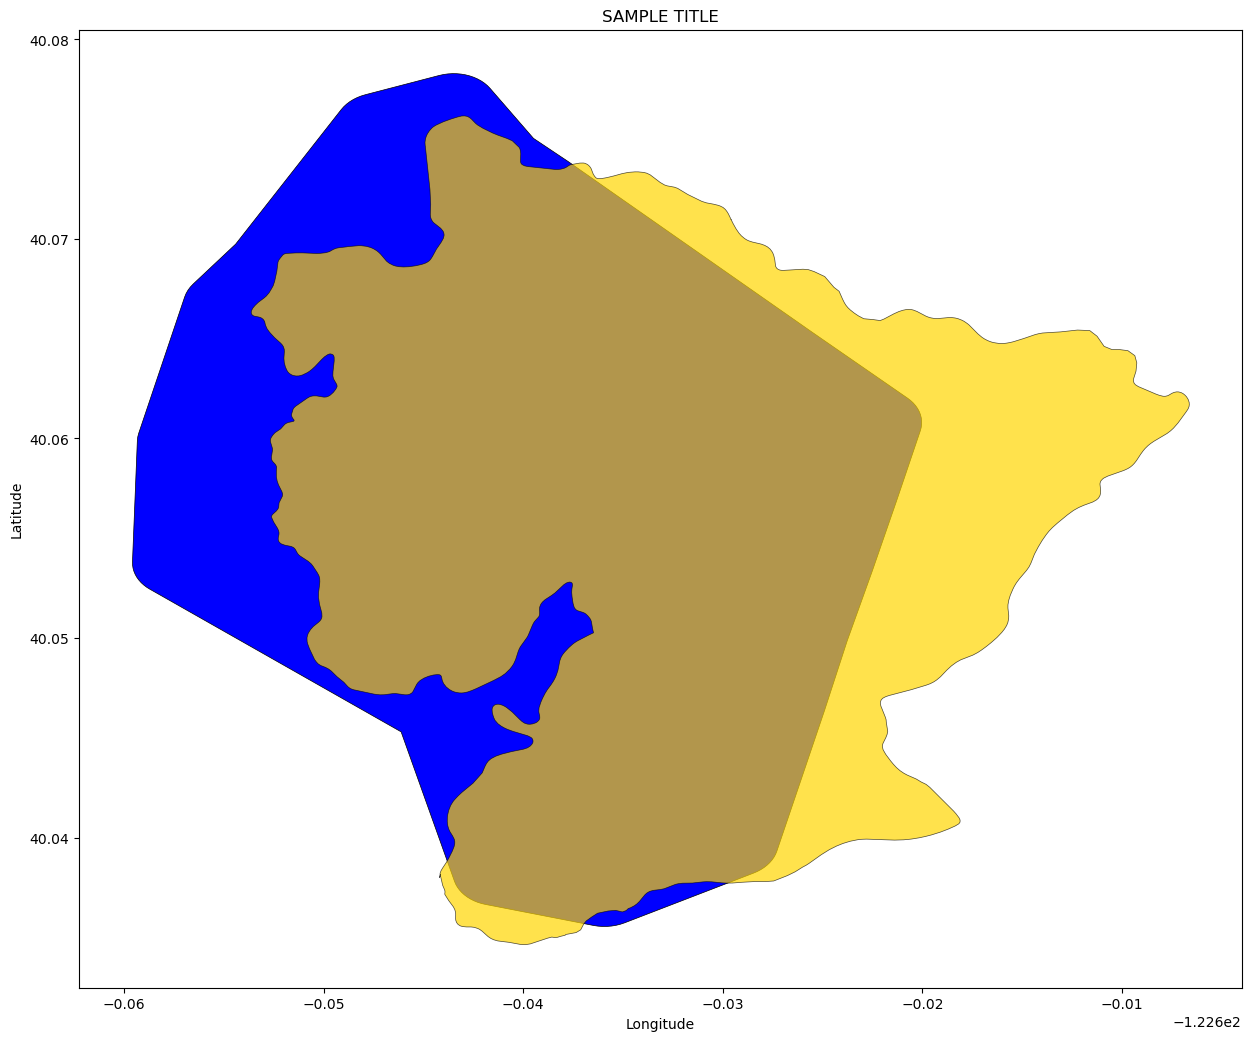

In [14]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15, 15))

sat_fire = all_satellite_polygons[all_satellite_polygons['index'] == 7716] 
aircraft_fire = all_aircraft_polygons[all_aircraft_polygons['index'] == 11374]

v = sat_fire.plot(ax=ax, legend=True, label="SATELLITE MATCH", color="blue",edgecolor="black", linewidth=0.5 )
n = aircraft_fire.plot(ax=ax, legend=True, label="AIRCRAFT MATCH", color="gold", edgecolor="black", linewidth=0.5, alpha=0.7)
# n = all_aircraft_polygons.plot(ax=ax, legend=True, label="CALFIRE MATCH", color="gold", edgecolor="black", linewidth=0.5, alpha=0.7)


ax.set_title("SAMPLE TITLE")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

xmin, ymin, xmax, ymax = sat_fire.geometry.total_bounds

# Set axis limits to zoom into the bounding box of 'sat_fire'
# ax.set_xlim(xmin, xmax)
# ax.set_ylim(ymin, ymax)

plt.show()

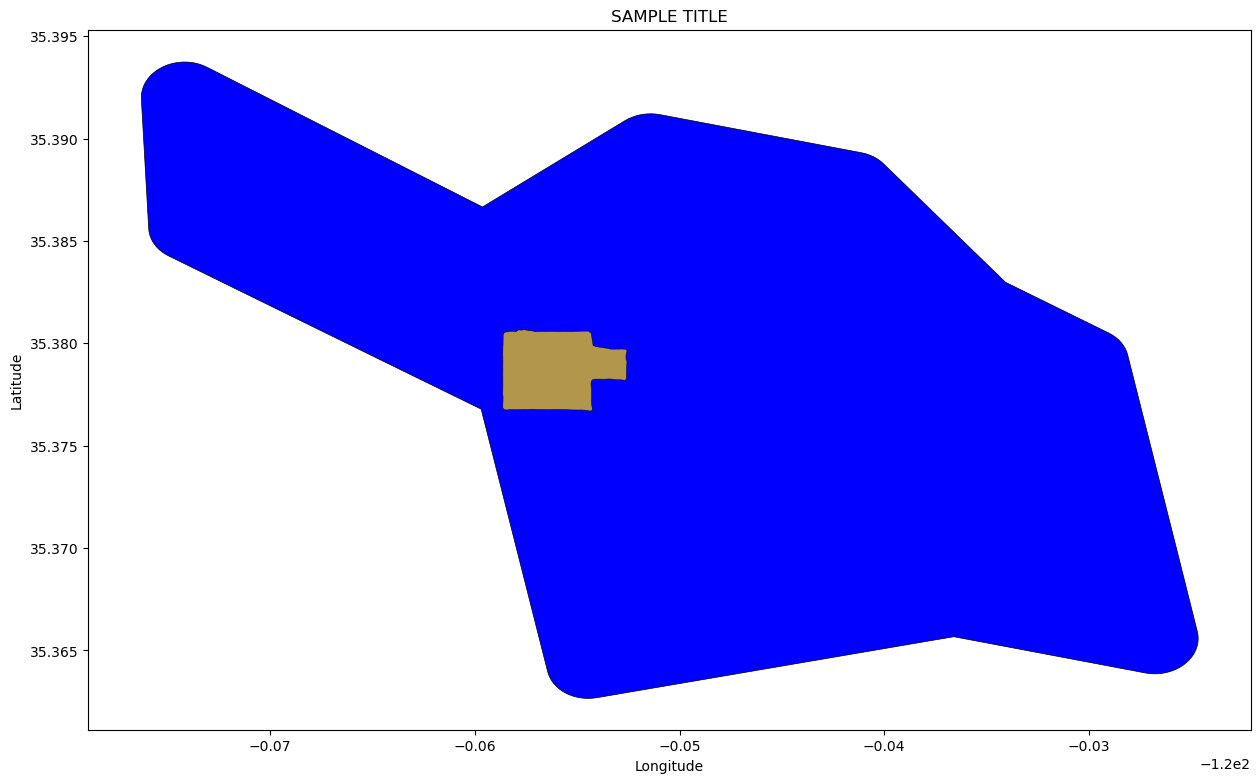

In [17]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15, 15))

sat_fire = all_satellite_polygons[all_satellite_polygons['index'] == 7962] 
aircraft_fire = all_aircraft_polygons[all_aircraft_polygons['index'] == 11449]

v = sat_fire.plot(ax=ax, legend=True, label="SATELLITE MATCH", color="blue",edgecolor="black", linewidth=0.5 )
n = aircraft_fire.plot(ax=ax, legend=True, label="AIRCRAFT MATCH", color="gold", edgecolor="black", linewidth=0.5, alpha=0.7)
# n = all_aircraft_polygons.plot(ax=ax, legend=True, label="CALFIRE MATCH", color="gold", edgecolor="black", linewidth=0.5, alpha=0.7)


ax.set_title("SAMPLE TITLE")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

xmin, ymin, xmax, ymax = sat_fire.geometry.total_bounds

# Set axis limits to zoom into the bounding box of 'sat_fire'
# ax.set_xlim(xmin, xmax)
# ax.set_ylim(ymin, ymax)

plt.show()

# Part 3: Simplification per fire; find best match

For every pair of fires, run best-simplification algorithm.
Basic plan; keep simplifying and track previous results for two generations. As soon as results degrade two times in a row, go back two times and declare the best version

### Generate an MP4 animation - Kincade

In [118]:
# grab kincade  
sat_fire = all_satellite_polygons[all_satellite_polygons['index'] == 7808] 
aircraft_fire = all_aircraft_polygons[all_aircraft_polygons['index'] == 11287]
# call 
result_thresh, simple_history, performance_history, tolerace_history = init_best_simplify(sat_fire, aircraft_fire, symmDiffRatioCalculation, False, 0, 0.1)
print(f"Best threshold value: {result_thresh}")
print(f"Index of best threshold value: {performance_history.index(max(performance_history))}")

Best threshold value: 0.1
Index of best threshold value: 0


### Other fires - run to set

In [127]:
# ranch - indexes at 7716 and 11374
sat_fire = all_satellite_polygons[all_satellite_polygons['index'] == 7716] 
aircraft_fire = all_aircraft_polygons[all_aircraft_polygons['index'] == 11374]
# call 
result_thresh, simple_history, performance_history, tolerace_history = init_best_simplify(sat_fire, aircraft_fire, symmDiffRatioCalculation, False, 0, 0.1)
print(f"Best threshold value: {result_thresh}")
print(f"Index of best threshold value: {performance_history.index(max(performance_history))}")

Best threshold value: 0.1
Index of best threshold value: 0


In [129]:
# briceburg
sat_fire = all_satellite_polygons[all_satellite_polygons['index'] == 8113] 
aircraft_fire = all_aircraft_polygons[all_aircraft_polygons['index'] == 11426]
result_thresh, simple_history, performance_history, tolerace_history = init_best_simplify(sat_fire, aircraft_fire, symmDiffRatioCalculation, False, 0, 0.1)
print(f"Best threshold value: {result_thresh}")
print(f"Index of best threshold value: {performance_history.index(max(performance_history))}")

Best threshold value: 0.005999999999999931
Index of best threshold value: 47


### MP4 Runner

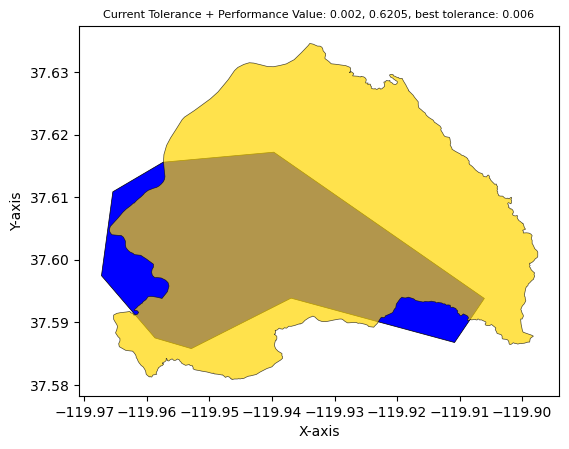

In [130]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from shapely.geometry import Polygon

fig, ax = plt.subplots()

def update(frame):
    ax.clear()
    
    # Plot the current polygon from simple_history against aircraft_fire
    current_polygon = simple_history[frame]  # Access geometry at current index
    current_poly_plot = current_polygon.plot(ax=ax, label="SATELLITE MATCH", color="blue", edgecolor="black", linewidth=0.5)
    aircraft_fire_plot = aircraft_fire.plot(ax=ax, label="AIRCRAFT MATCH", color="gold", edgecolor="black", linewidth=0.5, alpha=0.7)
    # fetch current threshold value used
    curr_tolerance = tolerace_history[frame]
    cur_calc = performance_history[frame]
    
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_title(f'Current Tolerance + Performance Value: {round(curr_tolerance, 4)}, {round(cur_calc, 4)}, best tolerance: {round(result_thresh, 4)}', fontsize=8)
    
    # Return the artists that change in each frame
    return [current_poly_plot, aircraft_fire_plot]
    

num_frames = len(simple_history)
ani = FuncAnimation(fig, update, frames=num_frames, interval=200)

# Save the animation as a GIF file
ani.save('polygons_animation.gif', writer='pillow', fps=10)

plt.show()

# Part 4: Mass calculations
See 2020 ipynb for additional output sample

In [135]:
result_dict = run_calculations(final_index_pairs, all_satellite_polygons, all_aircraft_polygons)
print_output(result_dict, all_satellite_polygons)

CALCULATED A RESULT: POLYGON FEDS AT INDEX 8113 AGAINST REFERENCE POLYGON AT INDEX 11426:
Ratio: 0.5399473817593282, Accuracy: 0.45618632453521973, Precision: 0.8527106234813815, Recall: 0.46041886854713626, IOU: 0, F1 0.5979670136795533, Symmetric Ratio: 0.6191096446650499
All measurements in units metre
CALCULATED A RESULT: POLYGON FEDS AT INDEX 7808 AGAINST REFERENCE POLYGON AT INDEX 11287:
Ratio: 1.0768937433017958, Accuracy: 1.5525343121533373, Precision: 0.8841178733805377, Recall: 0.9521010061847904, IOU: 0, F1 0.9168509551876862, Symmetric Ratio: 0.1726917309322174
All measurements in units metre
CALCULATED A RESULT: POLYGON FEDS AT INDEX 7716 AGAINST REFERENCE POLYGON AT INDEX 11374:
Ratio: 0.9908844458530985, Accuracy: 0.61440182906946, Precision: 0.7657478067044744, Recall: 0.7587675911095888, IOU: 0, F1 0.762241718940604, Symmetric Ratio: 0.4733492636338995
All measurements in units metre
CALCULATED A RESULT: POLYGON FEDS AT INDEX 7962 AGAINST REFERENCE POLYGON AT INDEX 114